In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

def prep_dataset(X,y):
    
    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [2]:
root = '../Malaria/cell_images/'
para = '/Parasitized/'
uninf = '/Uninfected/'

os.listdir(root)

['Parasitized', 'Uninfected']

In [3]:
Parasitized = os.listdir(root+para)
Uninfected = os.listdir(root+uninf)

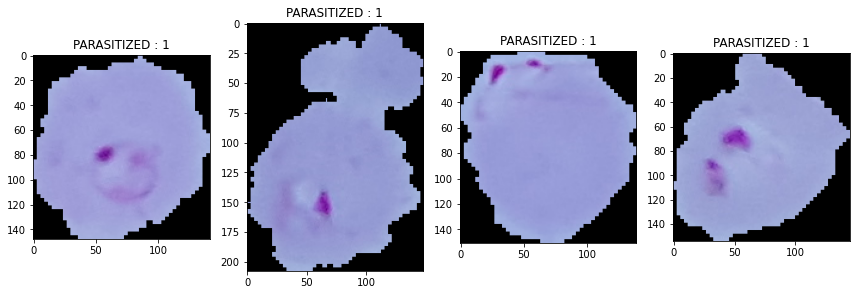

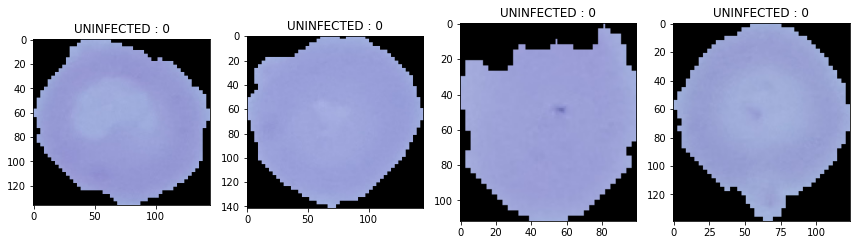

In [4]:
plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(root+para+ Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(root+uninf+ Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

In [5]:
data = []
labels = []

for img in Parasitized:
    try:
        img_read = plt.imread(root+para+ img)
        #img_gray = cv2.cvtColor(img_read, cv2.COLOR_BGR2GRAY)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in Uninfected:
    try:
        img_read = plt.imread(root+uninf+ img)
        #img_gray = cv2.cvtColor(img_read, cv2.COLOR_BGR2GRAY)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

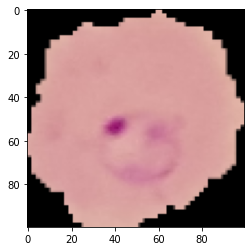

In [6]:
plt.imshow(data[0])
plt.show()

In [8]:
image_data = np.array(data)
labels = np.array(labels)

idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [9]:
image_data.shape

(27558, 100, 100, 3)

In [10]:
labels.shape

(27558,)

In [11]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(image_data,labels, test_size=0.15, shuffle=True,stratify=labels,random_state=42)
X_ts, X_val, Y_ts, Y_val = train_test_split(X_ts,Y_ts, test_size=0.5, stratify=Y_ts,random_state=42)


X_tr, Y_tr = prep_dataset(X_tr,Y_tr)
X_val, Y_val = prep_dataset(X_val,Y_val)
X_ts, _ = prep_dataset(X_ts,Y_ts)

In [12]:
model = models.Sequential()

#Input + Conv 1 + ReLU + Max Pooling
model.add(layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=X_tr.shape[1:]))

model.add(layers.MaxPool2D(strides=4))
model.add(layers.BatchNormalization())


# Conv 2 + ReLU + Max Pooling
model.add(layers.Conv2D(64,(5,5),padding='same',activation='relu'))

model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())


# Conv 3 + ReLU + Max Pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))

model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 4 + ReLU + Max Pooling
model.add(layers.Conv2D(256,(3,3),dilation_rate=(2,2),padding='same',activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Fully Connected + ReLU

model.add(layers.Flatten())

model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

#Output

model.add(layers.Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [13]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)

history= model.fit(X_tr,Y_tr,
                 epochs=20,
                 batch_size=50,
                 validation_data=(X_val,Y_val),
                 callbacks=[es])

Epoch 1/20
469/469 [==============================] - 594s 1s/step - loss: 0.3201 - accuracy: 0.8561 - val_loss: 0.7134 - val_accuracy: 0.5002
Epoch 2/20
469/469 [==============================] - 575s 1s/step - loss: 0.1314 - accuracy: 0.9552 - val_loss: 0.1597 - val_accuracy: 0.9569
Epoch 3/20
469/469 [==============================] - 551s 1s/step - loss: 0.1165 - accuracy: 0.9595 - val_loss: 0.1351 - val_accuracy: 0.9555
Epoch 4/20
469/469 [==============================] - 552s 1s/step - loss: 0.1069 - accuracy: 0.9628 - val_loss: 0.1167 - val_accuracy: 0.9632
Epoch 5/20
469/469 [==============================] - 566s 1s/step - loss: 0.1021 - accuracy: 0.9648 - val_loss: 0.1597 - val_accuracy: 0.9511
Epoch 6/20
469/469 [==============================] - 565s 1s/step - loss: 0.0919 - accuracy: 0.9678 - val_loss: 0.1211 - val_accuracy: 0.9579
Epoch 7/20
469/469 [==============================] - 556s 1s/step - loss: 0.0845 - accuracy: 0.9685 - val_loss: 0.1697 - val_accuracy: 0.9473

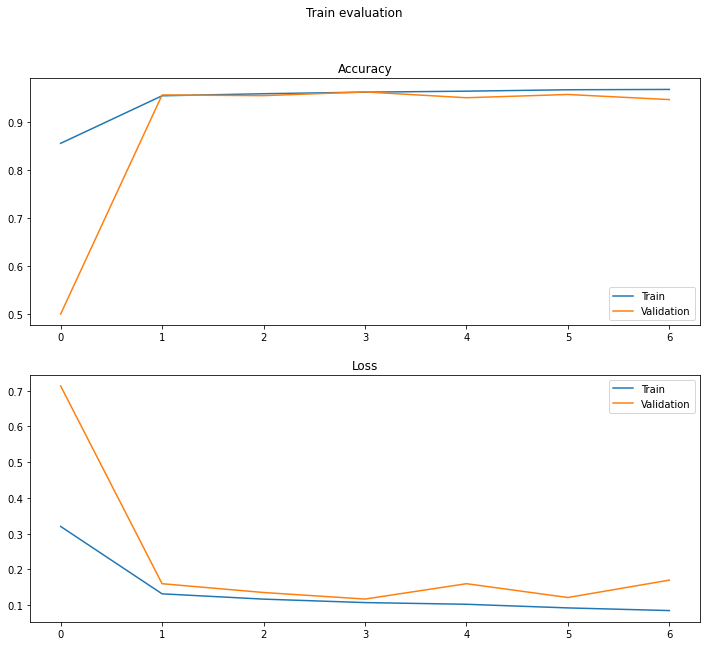

In [14]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')


plt.show()

In [15]:
Y_pred = model.predict(X_ts)

Y_pred = np.argmax(Y_pred, axis=1)

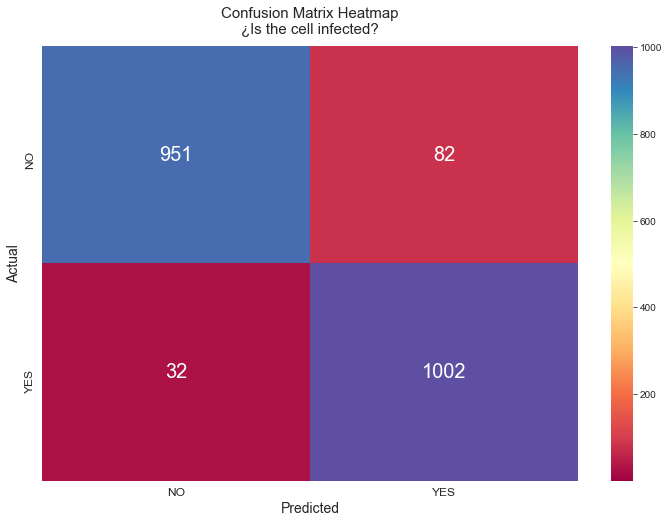

-Acuracy achieved: 94.48%
-Accuracy by model was: 96.85%
-Accuracy by validation was: 94.73%


In [18]:
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n¿Is the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
plt.show()


print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

## Error Sampling

In [19]:
index=0
index_errors= []

for label, predict in zip(Y_ts,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1

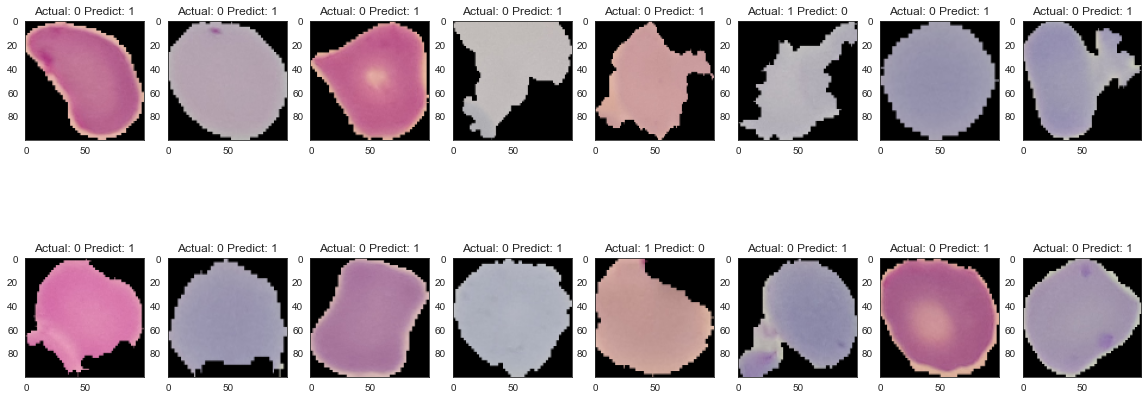

In [20]:
plt.figure(figsize=(20,8))

for i,img_index in zip(range(1,17),random.sample(index_errors,k=16)):
    plt.subplot(2,8,i)
    plt.imshow(np.reshape(255*X_ts[img_index], (100,100,3)))
    plt.title('Actual: '+str(Y_ts[img_index])+' Predict: '+str(Y_pred[img_index]))
plt.show()